In [1]:
import numpy


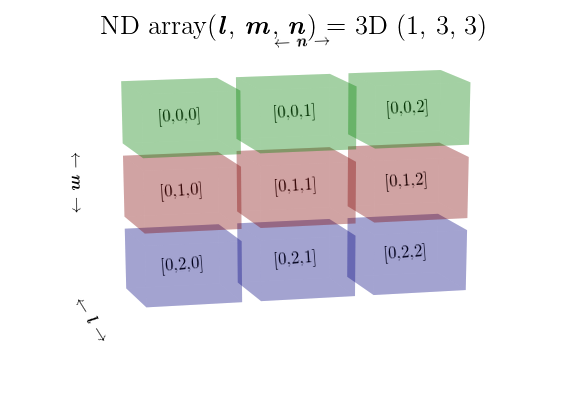

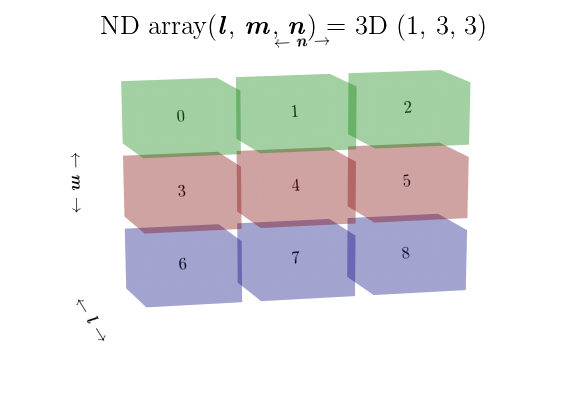

In [92]:

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
rcParams['axes.labelsize'] = 14
rcParams['axes.titlesize'] = 16
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['legend.fontsize'] = 14
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern Roman']
rcParams['text.usetex'] = True
rcParams['grid.alpha'] = 0.0

def make_element():
    """ A element consists of a bunch of planes/surfaces..."""

    element = {
        "top"    : np.asarray( [[[0,1],[0,1]], [[0,0],[1,1]], [[1,1],[1,1]]] ),
        "bottom" : np.asarray( [[[0,1],[0,1]], [[0,0],[1,1]], [[0,0],[0,0]]] ),
        "left"   : np.asarray( [[[0,0],[0,0]], [[0,1],[0,1]], [[0,0],[1,1]]] ),
        "right"  : np.asarray( [[[1,1],[1,1]], [[0,1],[0,1]], [[0,0],[1,1]]] ),
        "front"  : np.asarray( [[[0,1],[0,1]], [[0,0],[0,0]], [[0,0],[1,1]]] ),
        "back"   : np.asarray( [[[0,1],[0,1]], [[1,1],[1,1]], [[0,0],[1,1]]] )
    }

    return element

def apply_spacing(l, m, n, spacing=(None, 0,0,0)):
    """Position of array elements in relation to each other."""

    recipe, l_f, m_f, n_f = spacing
    if recipe not in [None, 'even', 'l', 'm', 'n']:
        raise TypeError("BAD")

    if recipe is None:
        return (0,0,0)
    elif recipe == 'even':
        return (l*l_f, m*m_f, n*n_f)
    elif recipe == 'l':
        return (l*l_f, l*m_f, l*n_f)
    elif recipe == 'm':
        return (m*l_f, m*m_f, m*n_f)
    elif recipe == 'n':
        return (n*l_f, n*m_f, n*n_f)
    else:
        raise TypeError("Unknown recipe[%s]" % recipe)

def text_coords(array, l, m, n):
    return "[%d,%d,%d]" % (l, m, n)

def text_values(array, l, m, n):
    return str(array[l,m, n])

class NDArrayPlotter(object):

    def __init__(
        self, 
        array,
        color="#0000FF",
        alpha="0.2",
        scale=(1, 1, 1),
        spacing=(None, 0,0,0)
    ):
        self.defaults_ = {
            "color":    color,
            "alpha":    alpha,
            "scale":    scale,
            "spacing":  spacing
        }
        self.reset(array)

    def reset(self, array):
        self.array_ = array

        self.set_color(self.defaults_["color"])
        self.set_alpha(self.defaults_["alpha"])
        self.set_spacing(self.defaults_["spacing"])
        self.set_scale(self.defaults_["scale"])

    def set_color(self, color):
        self.colors = np.zeros(self.array_.shape, dtype=('a10'))
        #self.colors = np.zeros(self.array_.shape, dtype=np.float32)
        self.colors[:] = color

        return self.colors

    def set_alpha(self, alpha):
        self.alphas = np.empty(self.array_.shape, dtype=np.float32)
        self.alphas[:] = alpha

        return self.alphas

    def set_scale(self, scale):
        self.scale = scale

        return self.scale

    def set_spacing(self, spacing):
        self.spacing = spacing

        return self.spacing

    def render(self, array=None, text=None, azim=-15, elev=15):
        if not array:
            array = self.array_

        if array.shape != self.array_.shape:
            reset(array)
        
        fig = plt.figure(dpi=120)
        ax = fig.add_subplot(111, projection='3d')

        element = make_element()

        for l in range(0, array.shape[0]):
            for m in range(0, array.shape[1]):
                for n in range(0, array.shape[2]):

                    # Extract settings that apply to all sides of the element
                    alpha = self.alphas[l, m, n]
                    lcolor = mcolors.to_rgba(self.colors[l, m, n].decode('UTF-8') , alpha)

                    relative_pos = apply_spacing(l, m, n, self.spacing)

                    for side in element:
                        (Ls, Ms, Ns) = (
                            self.scale[0]*(element[side][0] + l ) +relative_pos[0],
                            self.scale[1]*(element[side][1] + m ) +relative_pos[1],
                            self.scale[2]*(element[side][2] + n ) +relative_pos[2]
                        )
                        ax.plot_surface(
                            Ls, Ns, Ms,
                            rstride=1, cstride=1,
                            #alpha=alpha,
                            color= lcolor
                        )
                    
                    if text:

                        elmt_label = text(array, l, m, n)

                        elmt_center_coord = np.asarray([l,m,n])
                        elmt_center_coord = elmt_center_coord*np.asarray(self.scale) \
                                         + np.asarray(relative_pos)
                        elmt_center_coord = elmt_center_coord + np.asarray(self.scale)/2.0

                        elmt_label_coord = elmt_center_coord

                        ax.text(
                            elmt_label_coord[0], elmt_label_coord[2], elmt_label_coord[1], 
                            elmt_label,
                            horizontalalignment='center', verticalalignment='center',
                            zdir='y'
                        )

        highest = 0                         # Make it look cubic
        for size in array.shape:
            if size > highest:
                highest = size
        ax.set_xlim((0,highest))
        ax.set_ylim((0,highest))
        ax.set_zlim((0,highest))
        

        ax.set_title(r"ND array(\textbf{\emph{l}}, \textbf{\emph{m}}, \textbf{\emph{n}}) = %dD %s" % (array.ndim, str(array.shape)))

        plt.gca().invert_zaxis()

        #
        #   This is a crazy way to print axis-labels...
        #
        # x = l
        # y = n
        # z = m
        L, M, N = array.shape
        L_scl,  M_scl,  N_scl  = np.asarray(self.scale)
        L_skew, M_skew, N_skew = apply_spacing(L_scl, M_scl, N_scl, self.spacing)

        axis_label_format = r"$\leftarrow$ \textbf{\emph{%s}} $\rightarrow$"

        laxis_label = axis_label_format % "l" 
        maxis_label = axis_label_format % "m" 
        naxis_label = axis_label_format % "n" 

        ax.text(
            (L_scl*(L+L_skew))/2.0, -0.5, (M_scl*(M+M_skew))+0.5,
            laxis_label, zdir='x', horizontalalignment='center', verticalalignment='center'
        )
        ax.text(
            0, -0.5, (M_scl*(M+M_skew))/2.0, 
            maxis_label, zdir='z', horizontalalignment='center', verticalalignment='center'
        )
        ax.text(
            0, (N_scl*(N+N_skew))/2.0, -0.5, 
            naxis_label, zdir='y', 
        )
        plt.axis('off')

        """
        ax.set_xlabel('l') 
        ax.set_ylabel('n')
        ax.set_zlabel('m')
        # Get rid of the ticks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        # Get rid of the panes
        ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        # Get rid of the spines
        ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
        ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
        ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
        """
        #
        # End of crazy crazy way to print axis-labels
        #

        ax.view_init(azim=azim, elev=elev)

        return (fig, ax)

def start():
    

    """
    colors = plotter.colors
    colors[:] = "#00FF00"
    colors[ 0,  :, :] = "#FF0000"
    colors[-1,  :, :] = "#FF0000"
    colors[ :,  0, :] = "#FF0000"
    colors[ :, -1, :] = "#FF0000"
    colors[ :,  :, 0] = "#FF0000"
    colors[ :,  :,-1] = "#FF0000"
    alphas = plotter.alphas
    alphas[:] = 0.3
    alphas[ 0,  :, :] = 0.05
    alphas[-1,  :, :] = 0.05
    alphas[ :,  0, :] = 0.05
    alphas[ :, -1, :] = 0.05
    alphas[ :,  :, 0] = 0.05
    alphas[ :,  :,-1] = 0.05
    alphas = plotter.alphas
    alphas[:] = 0.05
    colors = plotter.set_color("#0000FF")
    colors[:,1,1] = "#FF0000"
    alphas[:,1,1] = 0.75
    colors[1,:,1] = "#FF0000"
    alphas[1,:,1] = 0.75
    """
    subject = np.arange(0,9).reshape((1,3,3))
    plotter = NDArrayPlotter(subject, spacing=('even', 0.2,0.2,0.2))
    
    colors = plotter.set_color("#0000FF")
    alphas = plotter.set_alpha(0.2)

    colors[:,1,:] = "#FF0000"
    colors[:,0,:] = "#00FF00"
    colors[:,2,:] = "#0000FF"

    (fig_coord, ax_coors) = plotter.render(text=text_coords)
    (fig_values, ax_value) = plotter.render(text=text_values)
    plt.show()

#if __name__ == "__main__":
start()

In [85]:
c = plotter.colors[0,0,0]
c.decode('UTF-8')


'#00FF00'

Populating the interactive namespace from numpy and matplotlib


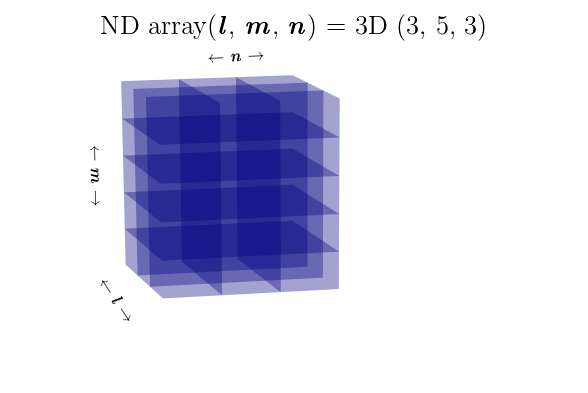

In [93]:
%pylab inline
import numpy as np
#import ndap
#reload(ndap)
subject = np.ones((3,5,3))
plotter = NDArrayPlotter(subject)
(fig, ax) = plotter.render()

In [35]:
from matplotlib import colors as mcolors

c = mcolors.to_rgba("#FF0000", alpha=0.6)
c

(1.0, 0.0, 0.0, 0.6)

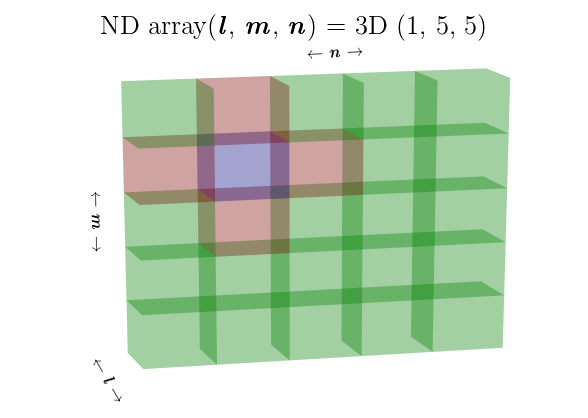

In [96]:
subject = np.ones((1,5,5))
plotter = NDArrayPlotter(subject)

plotter.set_scale((1.3,1.5,1.3))
colors = plotter.set_color("#00FF00")

i = 1
colors[0,i,i]   = "#0000FF"
colors[0,i,i+1] = "#FF0000"
colors[0,i,i-1] = "#FF0000"
colors[0,i+1,i] = "#FF0000"
colors[0,i-1,i] = "#FF0000"

(fig, ax) = plotter.render()

## Bokeh Plotting

In [1]:
from bokeh.plotting import figure 
from bokeh.io import output_notebook, show

In [2]:
output_notebook()

Loading BokehJS ...

In [3]:
from numpy import cos, linspace
x = linspace(-6, 6, 100)
y = cos(x)

p = figure(width=500, height=500)
p.circle(x, y, size=7, color="firebrick", alpha=0.5)
show(p)

In [5]:
from bokeh.sampledata.autompg import autompg
from bokeh.models import ColumnDataSource
from bokeh.layouts import gridplot

source = ColumnDataSource(autompg)

options = dict(plot_width=300, plot_height=300,
               tools="pan,wheel_zoom,box_zoom,box_select,lasso_select")

p1 = figure(title="MPG by Year", **options)
p1.circle("yr", "mpg", color="blue", source=source)

p2 = figure(title="HP vs. Displacement", **options)
p2.circle("hp", "displ", color="green", source=source)

p3 = figure(title="MPG vs. Displacement", **options)
p3.circle("mpg", "displ", size="cyl", line_color="red", fill_color=None, source=source)

p = gridplot([[ p1, p2, p3]], toolbar_location="right")

show(p)

### Lightning

In [6]:
from lightning import Lightning

from numpy import random

ModuleNotFoundError: No module named 'lightning'